Homwork n°2
Maxim Quénel
Cyprien Mouton
DIA 5

#Exercice 1 Partie B (problème du sac à dos)

##Data input

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time


data = pd.read_csv("items.csv", sep = ";", skiprows=1)

values = data['value'].values
weights = data['weight'].values

##Genetic Algorithm Implementation

In [2]:
max_weight = 10000  # Capacité maximale du sac

# Paramètres de l'algorithme génétique
population_size = 200
generations = 1000
crossover_rate = 0.8
mutation_rate = 0.2

# Initialisation de la population de manière aléatoire
def initialize_population(pop_size, num_items):
    return np.random.randint(2, size=(pop_size, num_items))#créer une matrice avec 200 solutions possibles dont chacune a une taille de 500 ce qui correspond au nombre de colis


# Fonction de fitness : calcule le poids totale et le score d'une solution
def fitness(individual):

    total_weight = np.sum(individual * weights)
    total_value = np.sum(individual * values)
    if total_weight > max_weight:
        return 0  # Si le poids dépasse la capacité, la solution est invalide
    else:
        return total_value


###Methode de sélection

In [3]:
# Sélection par tournoi
def selection(population, fitness_scores):
    selected = []
    best_index = np.argmax(fitness_scores)
    best_individual = population[best_index]
    for _ in range(len(population)):
        # Sélection de deux individus aléatoires et on prend le meilleur
        i, j = random.sample(range(len(population)), 2)
        if fitness_scores[i] > fitness_scores[j]:
            selected.append(population[i])
        else:
            selected.append(population[j])
    selected[0] = best_individual  # Remplace le premier individu par le meilleur actuel pour ne pas perdre la meilleur solution

    return np.array(selected) #Au final, selected contiens chaque gagnant des 200 tournoi (il pourra donc y avoir plusieurs fois la meme solution mais c'est le but pour favoriser les meilleur solution)


In [4]:

def roulette_wheel_selection(population, fitness_scores):
    total_fitness = np.sum(fitness_scores) #Additionne tout les score des 200 solutions présente dans la population
    if total_fitness == 0:  # Si toutes les solutions ont une fitness de 0
        return population[np.random.choice(len(population), size=len(population))] #Si aucunne des solution n'est viable, on retourne malgré tout cette population mais remplis de manière aléatoire avec les solution de la pop précédente
    probabilities = fitness_scores / total_fitness #pour normalisé
    selected_indices = np.random.choice(len(population), size=len(population), p=probabilities) # ainsi, les solutions avec les plus grandes probabilité (donc un meilleur fitness score) ont plus de chance d'étre selectionné
    return population[selected_indices]

###Methode de croisement

In [5]:

# Croisement (crossover) à un point
def crossover(parent1, parent2):
    if random.random() < crossover_rate: #On ne croise pas tout les parents pour garder une certaine base de l'ancienne générations
        point = random.randint(1, len(parent1) - 1) #Choisi de manière aléatoire le point de coupe pour combiné les deux parents
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])#Applique un mélange entre deux solutions à partir d'un certain index "point" (déterminé aléatoirement)
        return child1, child2
    else:
        return parent1, parent2


In [6]:

# Méthodes de croisement alternatives
def uniform_crossover(parent1, parent2):
    child1, child2 = parent1.copy(), parent2.copy()
    for i in range(len(parent1)):
        if random.random() < 0.5:
            child1[i], child2[i] = parent2[i], parent1[i]  #A chaque tour, si random.random est <0.5, ont modifie un gène de la solutions ce qui revient à avoir un croisement totalement différent de la methode précédente
    return child1, child2


###Mutation

In [7]:
# Mutation : on change aléatoirement un gène de l'individu
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < mutation_rate:  #On ne mute pas tout les éléments car cela n'aurais pas de sens.
            individual[i] = 1 - individual[i]# remplace un 0 par un 1 et un 1 par un 0 (ce qui reviens à dire que si on prenait le colis avant, maintenant on ne le prend plus et inversement)
    return individual


###Genetic algorith

In [8]:
# Algorithme génétique principal modifié
def genetic_algorithm(selection_method, crossover_method):
    population = initialize_population(population_size, len(weights))
    best_solution = None
    best_fitness = 0
    best_fitnesses = []
    mean_fitnesses = []
    best_weight = 0

    start_time = time.time()
    for generation in range(generations): #Pour 500 générations
        # Calcul des fitness
        fitness_scores = np.array([fitness(ind) for ind in population]) #Ceci renvoie un tableau avec le fitness score des 200 solutions proposé à une génération donné
        mean_fitnesses.append(np.mean(fitness_scores))


        max_fitness_idx = np.argmax(fitness_scores) # Conservation de la meilleure solution
        if fitness_scores[max_fitness_idx] > best_fitness: #Si le nouveau meilleur score est meilleur que l'ancien, on le remplace
            best_fitness = fitness_scores[max_fitness_idx]#On récupère le meilleur fitness pour pouvoir le comparé au prochaine générations
            best_solution = population[max_fitness_idx] #Ici, on récupère la meilleur solution trouvé pour un instant t
            best_weight = np.sum(best_solution*weights)

        best_fitnesses.append(best_fitness)

        # Sélection de methode de selection
        if selection_method == "roulette":
            selected_population = roulette_wheel_selection(population, fitness_scores)

        elif selection_method == "tournoi":
            selected_population = selection(population, fitness_scores)

        # Croisement et création de la nouvelle population
        new_population = []
        for i in range(0, population_size, 2): #Avec un pas de deux car lorsque l'on choisit parent1, parents est la solution suivante (i+1)
            parent1, parent2 = selected_population[i], selected_population[i + 1]
            if crossover_method == "one_point":
                child1, child2 = crossover(parent1, parent2)

            elif crossover_method == "uniform":
                child1, child2 = uniform_crossover(parent1, parent2)
            new_population.append(mutate(child1))
            new_population.append(mutate(child2)) #On ajoute les descandant des parents et on les mute en meme temps avant de les ajoutés à la nouvelle population

        population = np.array(new_population)



    runtime = time.time() - start_time
    return best_solution, best_fitness, best_fitnesses, mean_fitnesses, runtime,best_weight


##Methode Gloutonne

In [9]:
# Greedy Algorithm
def greedy_method(weights, values, max_weight):
    start_time = time.time()
    index_value_ratio = sorted(range(len(values)), key=lambda i: values[i] / weights[i], reverse=True) #Trie de manière croissante les colis par le ratio valeur/poids
    total_value, total_weight, solution = 0, 0, np.zeros(len(values))
    for i in index_value_ratio:
        if total_weight + weights[i] <= max_weight: #On rajoute d'abord les colis qui ont le meilleur ratio valeur/poids tant que le poids maximale n'est pas atteint
            solution[i] = 1
            total_value += values[i]
            total_weight += weights[i]
    runtime = time.time() - start_time
    return solution, total_value, runtime, total_weight


##Comparaisons

Test de l'algorithme génétique avec  roulette selection et one_point croisement
Test de l'algorithme génétique avec  tournoi selection et one_point croisement
Test de l'algorithme génétique avec  roulette selection et uniform croisement
Test de l'algorithme génétique avec  tournoi selection et uniform croisement
Test de la methode gloutonne personnalisé


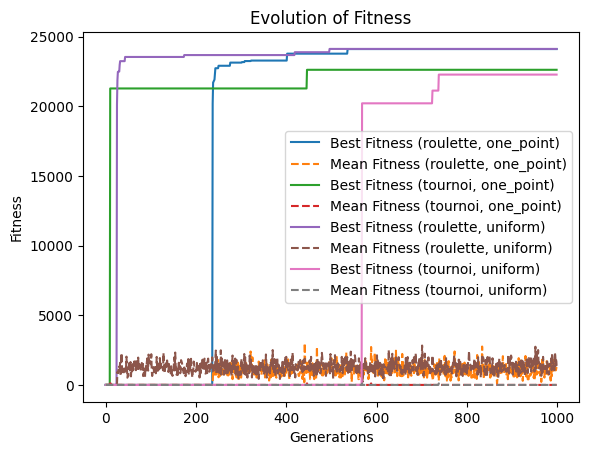


Résultat des comparaisons:
           Selection Croisement  Best Fitness    Runtime  poids
0           roulette  one_point         24108  30.193410   9772
1            tournoi  one_point         22620  27.478301   9850
2           roulette    uniform         24118  44.214561   9909
3            tournoi    uniform         22275  43.053624   9996
4  Methode Gloutonne                    35517   0.000629   9984


In [10]:

# Comparaison et tests
def compare_algorithms():
    # Test des configurations GA
    configurations = [
        ("roulette", "one_point"),
        ("tournoi", "one_point"),
        ("roulette", "uniform"),
        ("tournoi", "uniform"),
    ]
    results = []

    for selection_method, crossover_method in configurations: #Pour tester les 4 combinaisons possibles si dessus
        print(f"Test de l'algorithme génétique avec  {selection_method} selection et {crossover_method} croisement")
        best_solution, best_fitness, best_fitnesses, mean_fitnesses, runtime, poids_GA = genetic_algorithm(selection_method, crossover_method)
        results.append((selection_method, crossover_method, best_fitness, runtime, poids_GA))

        # Trace les courbes
        plt.plot(best_fitnesses, label=f"Best Fitness ({selection_method}, {crossover_method})")
        plt.plot(mean_fitnesses, linestyle="--", label=f"Mean Fitness ({selection_method}, {crossover_method})")

    # Exécution de l'algorithme glouton
    print("Test de la methode gloutonne personnalisé")
    greedy_solution, greedy_value, time_greedy, poids_greedy = greedy_method(weights, values, max_weight)
    results.append(("Methode Gloutonne", "", greedy_value, time_greedy, poids_greedy))  # Temps de calcul négligeable pour le glouton

    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.title("Evolution of Fitness")
    plt.legend()
    plt.show()

    # Résumé des résultats
    results_df = pd.DataFrame(results, columns=["Selection", "Croisement", "Best Fitness","Runtime", "poids"])
    print("\nRésultat des comparaisons:")
    print(results_df)

    return results_df

# Exécution de la comparaison
results = compare_algorithms()

##Interprétation

La meilleure solution ici est obtenue avec l’approche "Méthode Gloutonne", atteignant une fitness de 35517 avec un temps d’exécution extrêmement faible (0.0006 secondes).

En comparaison, la meilleure fitness parmi les Algorithmes Génétiques (GA) est 23986 obtenue avec la méthode "roulette + uniform crossover". Bien que les GA explorent des solutions potentielles variées, l'approche gloutonne se distingue en trouvant une solution optimale plus rapidement et efficacement.

Les paramètre du GA peuvent etre modifié mais cela ne change pas énormément par rapport au résultat finale.

Ce n'est pas parceque le nombre de génération augmente que la solution finale sera meilleur (en autre car il y a un problème de convergence lié au GA)

Le graphique montre l’évolution de la fitness moyenne et maximale pour différentes configurations de GA :

Les configurations roulette + one_point et roulette + uniform montrent une croissance plus rapide et stable, atteignant des fitness élevées. Cependant, elles convergent parfois trop tôt, limitant leur capacité d'exploration.

La méthode tournoi tend à être plus stable, bien qu'elle converge plus lentement que "roulette". Les performances sont légèrement inférieures, mais elle offre une meilleure exploration dans certains cas.

Les GA ont tendance à converger autour de 200-250 générations.

Le crossover "uniform" semble permettre une exploration plus large (meilleure fitness), mais au coût d’un temps de calcul plus long.

Les différentes stratégies de sélection et de crossover ont des impacts variés sur les performances :

Roulette : Favorise les individus avec une fitness élevée, ce qui peut entraîner une convergence rapide mais aussi un risque de stagnation.

Tournament : Encourage une compétition plus équilibrée, explorant davantage l’espace des solutions mais parfois au détriment de la vitesse.

One-point crossover : Simple mais peut manquer de diversité génétique dans les générations.

Uniform crossover : Plus efficace pour explorer des solutions diverses, mais nécessite plus de calculs.

En termes de compromis, "roulette + uniform" semble offrir un bon équilibre entre convergence et exploration.

Forces des GA :
Adaptés aux problèmes où il n’existe pas de méthode analytique directe pour trouver une solution optimale.
Permettent d'explorer un espace de solutions plus large, potentiellement trouvant des solutions proches de l’optimum pour des problèmes complexes.

Faiblesses des GA :
Temps de calcul plus élevé par rapport à une approche gloutonne.
Risque de convergence prématurée sur un optimum local.
Nécessité de calibrer plusieurs hyperparamètres (taille de population, mutation, crossover, etc.).

Forces de la méthode gloutonne :
Rapidité et simplicité d’implémentation.
Trouve souvent des solutions optimales ou quasi-optimales pour des problèmes simples comme celui-ci.

Faiblesses de la méthode gloutonne :
Peu adaptée aux problèmes où les solutions optimales nécessitent une exploration non linéaire.
Peut échouer à trouver la solution optimale dans des problèmes avec des contraintes ou relations complexes entre les éléments.

En conclusion, pour ce problème spécifique, la méthode gloutonne est clairement supérieure en termes de performance et de temps de calcul. Cependant, les GA restent une solution puissante pour des problèmes où l’espace des solutions est complexe ou où les relations entre les contraintes et les objectifs ne permettent pas une résolution analytique directe.